In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seabornInstance 

from pandas import merge
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import pearsonr

%matplotlib inline

from sklearn import preprocessing
pd.options.mode.chained_assignment = None  # default='warn'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


###  <font color=blue> Importing StreetEasy Data <font>

In [2]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test1_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
test2_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
test3_df_ = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

###  <font color=blue> Importing Additional Data <font>

In [3]:
#https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv/data
dob_complaints_df_ = pd.read_csv('C:/Users/new/Downloads/data/DOB_Complaints_Received.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
#https://data.cityofnewyork.us/Housing-Development/DOB-Violations/3h2n-5cm9/data
dob_violations_df_ = pd.read_csv('C:/Users/new/Downloads/data/DOB_Violations.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
#https://data.cityofnewyork.us/City-Government/Revised-Notice-of-Property-Value-RNOPV-/8vgb-zm6e/data
property_value_df_ = pd.read_csv('C:/Users/new/Downloads/data/Revised_Notice_of_Property_Value__RNOPV_.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
master_df=train_df
test1_df = test1_df_
test2_df = test2_df_
test3_df = test3_df_
dob_complaints_df = dob_complaints_df_
dob_violations_df = dob_violations_df_
property_value_df = property_value_df_

###  <font color=blue> Cleaning and Preprocessing Data <font>

In [67]:
# keeeping only bin number and property values columns for property_value dataset
property_value_df = property_value_df[['BIN','ORIGINAL MARKET VALUE']].copy()

In [68]:
# get number of violations per each bin number and keep only bin nunber and count
dob_violations_df['ISSUE_DATE'] =  pd.to_datetime(dob_violations_df['ISSUE_DATE'], format='%Y%m%d', errors='coerce')
dob_violations_df = dob_violations_df[(dob_violations_df['ISSUE_DATE'].dt.year > 2010) ]
bin_violations = dob_violations_df.BIN.value_counts().reset_index().rename(columns={'index': 'z', 0: 'count'})

In [69]:
# get number of violations per each bin number and keep only bin nunber and count
dob_complaints_df['Date Entered'] =  pd.to_datetime(dob_complaints_df['Date Entered'], format='%m/%d/%Y')
dob_complaints_df  = dob_complaints_df[(dob_complaints_df['Date Entered'].dt.year > 2010) ]
bin_complaints = dob_complaints_df.BIN.value_counts().reset_index().rename(columns={'index': 'z', 0: 'count'})

In [70]:
# merge violations df with master df
def add_dob_violations_to_dataset(x):
    #x = pd.merge(left=x,right=bin_violations,  how = 'left', left_on = 'bin', right_on = 'z')
    x = x.merge(right=bin_violations,  how = 'left', left_on = 'bin', right_on = 'z', right_index = True)
    x.rename(columns={'BIN': 'dob_violations_count'}, inplace=True)
    x.drop('z', axis=1, inplace=True)
    return x

# merge complaints df with master df
def add_dob_complaints_to_dataset(x):
    #x = pd.merge(left=x,right=bin_complaints,  how='left', left_on='bin', right_on='z')
    x = x.merge(right=bin_complaints,  how='left', left_on='bin', right_on='z', right_index = True)
    x.rename(columns={'BIN': 'dob_complaints_count'}, inplace=True)
    x.drop('z', axis=1, inplace=True)
    return x
    
# merge property value df with master df
def add_dob_property_tax_to_dataset(x):
    x = pd.merge(left=x,right=property_value_df,  how='left', left_on='bin', right_on='ORIGINAL MARKET VALUE')
    #x = x.merge(right=property_value_df,  how='left', left_on='bin', right_on='ORIGINAL MARKET VALUE', right_index = True)
    x.rename(columns={'ORIGINAL MARKET VALUE': 'market_value'}, inplace=True)
    x.drop('BIN', axis=1, inplace=True)
    return x

In [71]:
# append additonal data to street easy data
master_df = add_dob_complaints_to_dataset(master_df)
master_df = add_dob_violations_to_dataset(master_df)
#master_df = add_dob_property_tax_to_dataset(master_df)

In [72]:
# features
feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 'size_sqft', 'no_fee', 'addr_zip', 'floornumber', 'floor_count', 
    'has_doorman', 'has_fireplace', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage',
    'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'dob_complaints_count', 'dob_violations_count'
]

def fill_missing_values(train_features):
    train_features['dob_complaints_count'] = train_features['dob_complaints_count'].fillna(0)
    train_features['dob_violations_count'] = train_features['dob_violations_count'].fillna(0)
    train_features['bedrooms'] = train_features['bedrooms'].median()
    train_features['bathrooms'] = train_features['bathrooms'].median()
    train_features['size_sqft'] = train_features['size_sqft'].median()
    train_features['floornumber'] = train_features['floornumber'].median()
    train_features['floor_count'] = train_features['floor_count'].mean()
    train_features['year_built'] = train_features['year_built'].mean()
    train_features['min_to_subway'] = train_features['min_to_subway'].mean()
    train_features['no_fee'] = train_features['no_fee'].fillna(0)
    train_features['has_doorman'] = train_features['has_doorman'].fillna(0)
    train_features['has_fireplace'] = train_features['has_fireplace'].fillna(0) 
    train_features['has_gym'] = train_features['has_gym'].fillna(0)
    train_features['allows_pets'] = train_features['allows_pets'].fillna(0)
    train_features['has_washer_dryer'] = train_features['has_washer_dryer'].fillna(0)
    train_features['has_garage'] = train_features['has_garage'].fillna(0)
    train_features['has_roofdeck'] = train_features['has_roofdeck'].fillna(0) 
    train_features['has_concierge'] = train_features['has_concierge'].fillna(0)
    train_features['has_pool'] = train_features['has_pool'].fillna(0),
    train_features['has_garden'] = train_features['has_garden'].fillna(0)
    return train_features
        '''
    train_features = train_features.fillna({
        'bedrooms': train_features['bedrooms'].median(),
        'bathrooms': train_features['bathrooms'].median(),
        'size_sqft': train_features['size_sqft'].median(), 
        'floornumber': train_features['floornumber'].median(),
        #'market_value': train_features['market_value'].median(),
        'floor_count': train_features['floor_count'].mean(),
        'year_built': train_features['year_built'].mean(),
        'min_to_subway': train_features['min_to_subway'].mean(),
        'no_fee': 0,
        'has_doorman':0, 
        'has_fireplace':0, 
        'has_gym':0, 
        'allows_pets':0, 
        'has_washer_dryer':0, 
        'has_garage':0,
        'has_roofdeck':0, 
        'has_concierge':0, 
        'has_pool':0, 
        'has_garden':0,
        'dob_complaints_count':0, 
        'dob_violations_count':0
    })#, inplace=True)
    return train_features
    '''

IndentationError: unexpected indent (<ipython-input-72-6a00fad703f1>, line 30)

In [ ]:
# Getting rid of the top 5 percent by normalizing all rents based on range of rents

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

#rents = normalize(master_df['rent'].values)
#rents = list(filter(lambda x: x < 0.95, rents))

###  <font color=blue> Handle Training Data Missing Values <font>

In [ ]:
master_df = master_df[( master_df['size_sqft'] < 2300) ]
master_df = master_df[( master_df['size_sqft']  >  0) ]
master_df = master_df[(master_df['bedrooms'] > 0) ]
master_df = master_df[(master_df['bedrooms'] < 6) ]
master_df = master_df[(master_df['rent'] < 10000) ]
master_df = master_df[(master_df['bathrooms'] < 4) ]
master_df = master_df[(master_df['floor_count'] < 50) ]

master_df = fill_missing_values(master_df)
train_features = master_df[feature_cols] 

train_target = master_df['rent']

## <font color=blue> Visualization of Data <font>


In [ ]:
# detemrine correaltion between rent and other variables

a = ['bedrooms', 'bathrooms', 'size_sqft', 'floornumber', 'floor_count','year_built' ,'min_to_subway','no_fee','has_doorman' , 'has_fireplace' , 'has_gym' , 'allows_pets' ,'has_washer_dryer' , 'has_garage' ,'has_roofdeck' , 'has_concierge' , 'has_pool' , 'has_garden' ,'dob_complaints_count' , 'dob_violations_count']

print('Pearsons correlation\n')

for i in a:
    corr, _ = pearsonr(master_df['rent'], master_df[i])
    print('rent,'+ i + ':   ' + str(corr))


In [ ]:
plt.figure(figsize=(15,10))
plt.scatter( master_df['size_sqft'], master_df['rent'],  s=5)
plt.title("NYC Rents: Square Feet vs Rent")
plt.xlabel("Square Feet (feet)")
plt.ylabel("Rent (Dollars)")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Distribution of Apartments Available in terms of Square Feet')
seabornInstance.distplot(master_df['size_sqft'])

In [ ]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Apartments Available in terms of Rent')
seabornInstance.distplot(master_df['rent'])

In [ ]:
temp=master_df.iloc[:,1:-1]
corr = temp.corr()
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(temp.columns),1)

ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_df.columns)
ax.set_yticklabels(train_df.columns)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(test1_df['addr_lon'],test1_df['addr_lat'], marker = ',')
plt.title('Apartments Available (Grid)')

#  <font color=green> Test 1 <font>

In [ ]:
#master_df.head(1)

In [ ]:
# impute missing values 
test1_df = add_dob_complaints_to_dataset(test1_df)
test1_df = add_dob_violations_to_dataset(test1_df)
test1_df = fill_missing_values(test1_df)

test1_features = test1_df[feature_cols]

#### Linear Regression Model

In [73]:
lreg = LinearRegression()
lreg.fit(train_features, train_target)

test1_df['predicted'] = lreg.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])

3546992.690203936

#### Random Forest Regression Model


In [74]:
regressor = RandomForestRegressor(n_estimators = 50, random_state = 1, max_depth = 42)
regressor.fit(train_features, train_target)

test1_df['predicted'] = regressor.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])

3666514.2933104

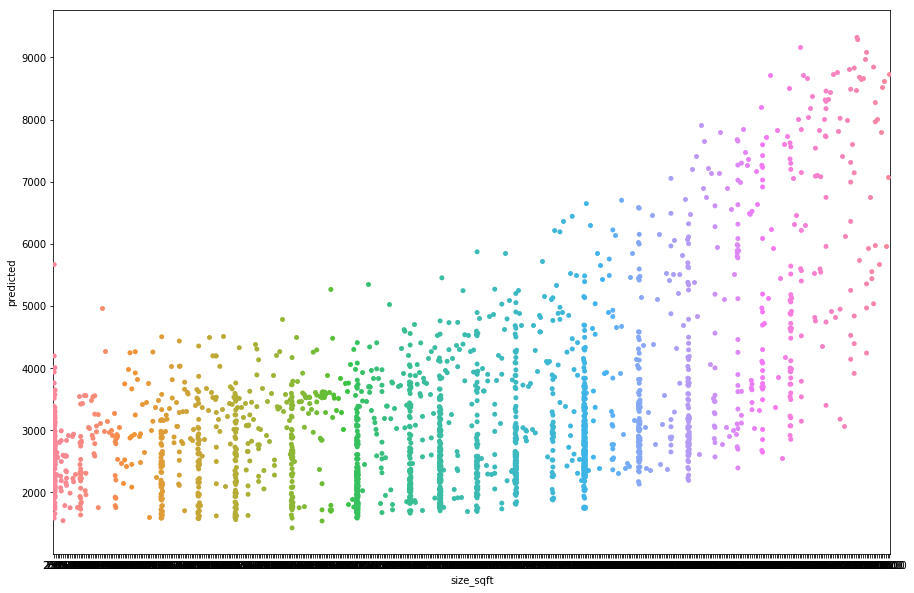

In [75]:
plt.figure(figsize=(15,10))
seabornInstance.swarmplot(x="size_sqft", y="predicted", data=test1_df)

#  <font color=green> Test 2 <font>


#### Combine Train Data and test1 data

In [76]:
test1_df['rent']

rental_id
7499437     2700
7477903     1650
7481023     2900
7479547     4750
7518814     1800
7524679     3987
7441537     3500
7523245     3000
7516717     2095
7523536     4346
7519651     2100
7441630     4995
7522765     2150
7452826     2275
7500427     2600
7466614     2595
7464721     3300
7446442    23000
7471321     3450
7448446     3500
7515463     4175
7464994     6200
7430950     3985
7443730     2250
7472581     1900
7497742     3000
7470814     1450
7444810     3600
7508281     2250
7434526     5700
           ...  
7443601     3395
7525285     1650
7433635     8650
7516393     1675
7486066     5800
7521223     1865
7441411     3400
7525294     1500
7430374     1400
7437217     6200
7435615     2695
7430287     1700
7493593     1750
7469836     4095
7464919     1795
7516267     9163
7445845     2900
7429897     2200
7524892     4700
7438600     2995
7437901     1700
7517914     2195
7459837     5990
7500382     5395
7484878     1700
7480060     7155
7444102     3200
7499

In [77]:
master_df = master_df.append(test1_df, sort=False) 

#### Handle Training Data Missing Values

In [78]:
# impute missing values with medians
test2_df = add_dob_complaints_to_dataset(test2_df)
test2_df = add_dob_violations_to_dataset(test2_df)
test2_df = fill_missing_values(test2_df)

test2_features = test2_df[feature_cols]

#### Random Forest Regression Model

In [79]:
master_target = master_df['rent']
master_features = master_df[feature_cols]
master_features = fill_missing_values(master_features)

print(test1_df['rent'].isna().sum())


#test2_features.head(20).transpose()

regressor.fit(master_features, master_target)
test2_df['rent'] = regressor.predict(test2_features)

0


In [81]:
test2_df['rent'].to_csv('test2_results.csv', header=True)

In [82]:
master_df.columns
#test1_df['dob_violations_count'].fillna(0)

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line',
       'dob_complaints_count', 'dob_violations_count', 'predicted'],
      dtype='object')

#  <font color=green> Test 3 <font>


#### Combine Train Data and test1 data

In [83]:
master_df = master_df.append(test2_df,  sort=False) 

#### Handle Training Data Missing Values

In [84]:
# impute missing values 
test3_df = add_dob_complaints_to_dataset(test3_df)
test3_df = add_dob_violations_to_dataset(test3_df)
test3_df = fill_missing_values(test3_df)

test3_features = test3_df[feature_cols]

In [85]:
master_target = master_df['rent']
master_features = master_df[feature_cols]
master_features = fill_missing_values(master_features)

regressor.fit(master_features, master_target)
test3_df['rent'] = regressor.predict(test3_features)

In [86]:
test3_df['rent'].to_csv('test3_results.csv', header=True)

In [ ]:
#df = master_df[(master_df['dob_violations_count'] != 'NaN') ]
#gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
#gb.fit(train_features, train_target)
#test1_df['predicted'] = gb.predict(test_features)
#mean_squared_error(test1_df['rent'], test1_df['predicted'])
#3487743.630438365
#2674320.2628589286


#master_df.head(5)
gb = GradientBoostingRegressor()
gb.fit(train_features, train_target)

test1_features = test1_df[feature_cols]
test1_features = test1_features.fillna(master_df.median(), axis=0)
test1_features = pd.get_dummies(test1_features)

test1_df['predicted'] = gb.predict(test1_features)
mean_squared_error(test1_df['rent'], test1_df['predicted'])